In [1]:
import pandas as pd
import numpy as np
import xgboost as xgb
import matplotlib as plt
from sklearn.metrics import confusion_matrix, accuracy_score, classification_report, roc_auc_score, make_scorer, balanced_accuracy_score, ConfusionMatrixDisplay
from sklearn.model_selection import train_test_split, GridSearchCV, RandomizedSearchCV
from ucimlrepo import fetch_ucirepo 
from sklearn.utils import class_weight
from imblearn.over_sampling import SMOTE
from imblearn.pipeline import Pipeline as ImbPipeline
from sklearn.metrics import precision_recall_fscore_support
from scipy.stats import randint, uniform
from xgboost import XGBClassifier
from sklearn.multiclass import OneVsOneClassifier
from sklearn.ensemble import RandomForestClassifier

In [2]:
df=pd.read_csv('Resources/data.csv',delimiter=';')
df['Target'] = pd.Categorical(df['Target'])
df['Target'] = df['Target'].cat.codes
print(df['Target'].value_counts())
df.head()

Target
2    2209
0    1421
1     794
Name: count, dtype: int64


Marital status  Application mode  Application order  Course  \
0               1                17                  5     171   
1               1                15                  1    9254   
2               1                 1                  5    9070   
3               1                17                  2    9773   
4               2                39                  1    8014   

   Daytime/evening attendance\t  Previous qualification  \
0                             1                       1   
1                             1                       1   
2                             1                       1   
3                             1                       1   
4                             0                       1   

   Previous qualification (grade)  Nacionality  Mother's qualification  \
0                           122.0            1                      19   
1                           160.0            1                       1   
2                           122.0            1                      37   
3                           122.0            1                      38   
4                           100.0            1                      37   

   Father's qualification  ...  Curricular units 2nd sem (credited)  \
0                      12  ...                                    0   
1                       3  ...                                    0   
2                      37  ...                                    0   
3                      37  ...                                    0   
4                      38  ...                                    0   

   Curricular units 2nd sem (enrolled)  \
0                                    0   
1                                    6   
2                                    6   
3                                    6   
4                                    6   

   Curricular units 2nd sem (evaluations)  \
0                                       0   
1                                       6   
2                                       0   
3                                      10   
4                                       6   

   Curricular units 2nd sem (approved)  Curricular units 2nd sem (grade)  \
0                                    0                          0.000000   
1                                    6                         13.666667   
2                                    0                          0.000000   
3                                    5                         12.400000   
4                                    6                         13.000000   

   Curricular units 2nd sem (without evaluations)  Unemployment rate  \
0                                               0               10.8   
1                                               0               13.9   
2                                               0               10.8   
3                                               0                9.4   
4                                               0               13.9   

   Inflation rate   GDP  Target  
0             1.4  1.74       0  
1            -0.3  0.79       2  
2             1.4  1.74       0  
3            -0.8 -3.12       2  
4            -0.3  0.79       2  

[5 rows x 37 columns]

In [3]:
def load_data(path,target_column,categorical=None,delimiter=','):
    df=pd.read_csv(path,delimiter=delimiter)
    df[target_column] = pd.Categorical(df[target_column])
    df[target_column] = df[target_column].cat.codes
    print(df[target_column].value_counts())
    y=df[target_column]
    X=df.drop(columns=target_column)
    if categorical != None:
        X=pd.get_dummies(X,columns=categorical).astype(int) # I put astype int here because my enviorment has some quirk where get dummies gives boolean values
    X_train,X_test,y_train,y_test=train_test_split(X,y,random_state=1,test_size=0.2, stratify=y)
    return X_train,X_test,y_train,y_test

In [5]:
path='Resources/data.csv'
delimiter = ';'
target_column='Target'
categorical=['Marital status','Application mode','Course','Previous qualification','Nacionality',"Mother's qualification","Father's qualification","Mother's occupation","Father's occupation",]
X_train,X_test,y_train,y_test=load_data(path=path,target_column=target_column,categorical=categorical,delimiter=delimiter)
# model dictionary retrieved in optimization process.
model={'id': 4, 'weights': {0: 0.8, 1: 1.5, 2: 0.6}, 'parameters': {'gamma': 0.16265564130892807, 'learning_rate': 0.21852145937893902, 'max_depth': 6, 'reg_lambda': 2, 'subsample': 0.8675099502159194, 'tree_method': 'hist', 'eval_metric': 'aucpr', 'objective': 'multi:softprob', 'random_state': 1, 'num_class': 3, 'device': 'cuda'}, 'f1': 0.5567567567567568, 'recall': 0.6477987421383647, 'precision': 0.4881516587677725, 'full_report': '              precision    recall  f1-score   support\n\n           0       0.84      0.71      0.77       284\n           1       0.49      0.65      0.56       159\n           2       0.85      0.84      0.84       442\n\n    accuracy                           0.76       885\n   macro avg       0.73      0.73      0.72       885\nweighted avg       0.78      0.76      0.77       885\n'}
# Convert your data to DMatrix format
smote=SMOTE()
X_resampled, y_resampled = smote.fit_resample(X_train, y_resampled)

dtrain = xgb.DMatrix(X_resampled, label=y_resampled, nthread=-1)
dtest = xgb.DMatrix(X_test, label=y_test, nthread=-1)

xgb_clf=XGBClassifier(**model['parameters'])
weight_02=class_weight.compute_sample_weight(model['weights'],y=y_resampled)
xgb_clf.fit(X_resampled,y_resampled,sample_weight=weight_02,eval_set=[(X_test,y_test)])


Target
2    2209
0    1421
1     794
Name: count, dtype: int64
[0]	validation_0-aucpr:0.69104
[1]	validation_0-aucpr:0.70633
[2]	validation_0-aucpr:0.70861
[3]	validation_0-aucpr:0.71519
[4]	validation_0-aucpr:0.72446
[5]	validation_0-aucpr:0.72506
[6]	validation_0-aucpr:0.72363
[7]	validation_0-aucpr:0.72309
[8]	validation_0-aucpr:0.72449
[9]	validation_0-aucpr:0.71866
[10]	validation_0-aucpr:0.71953
[11]	validation_0-aucpr:0.72416
[12]	validation_0-aucpr:0.72855
[13]	validation_0-aucpr:0.73436
[14]	validation_0-aucpr:0.73631
[15]	validation_0-aucpr:0.73872
[16]	validation_0-aucpr:0.73702
[17]	validation_0-aucpr:0.73508
[18]	validation_0-aucpr:0.73637
[19]	validation_0-aucpr:0.74062
[20]	validation_0-aucpr:0.73999
[21]	validation_0-aucpr:0.74224
[22]	validation_0-aucpr:0.74222
[23]	validation_0-aucpr:0.74166
[24]	validation_0-aucpr:0.74049
[25]	validation_0-aucpr:0.73943
[26]	validation_0-aucpr:0.73982
[27]	validation_0-aucpr:0.74151
[28]	validation_0-aucpr:0.74138
[29]	validation_0-a

XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, device='cuda', early_stopping_rounds=None,
              enable_categorical=False, eval_metric='aucpr', feature_types=None,
              gamma=0.16265564130892807, grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=0.21852145937893902,
              max_bin=None, max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=6, max_leaves=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              multi_strategy=None, n_estimators=None, n_jobs=None, num_class=3,
              num_parallel_tree=None, ...)

## The data has now been prepared

## Bellow has good results

Fitting 3 folds for each of 2 candidates, totalling 6 fits
Best parameters found:  {'gamma': 0.25, 'learning_rate': 0.2, 'max_depth': 5, 'reg_lambda': 6.0}
              precision    recall  f1-score   support

           0       0.85      0.71      0.77       284
           1       0.57      0.45      0.51       159
           2       0.79      0.93      0.85       442

    accuracy                           0.77       885
   macro avg       0.74      0.70      0.71       885
weighted avg       0.77      0.77      0.76       885

Accuracy:  0.7728813559322034


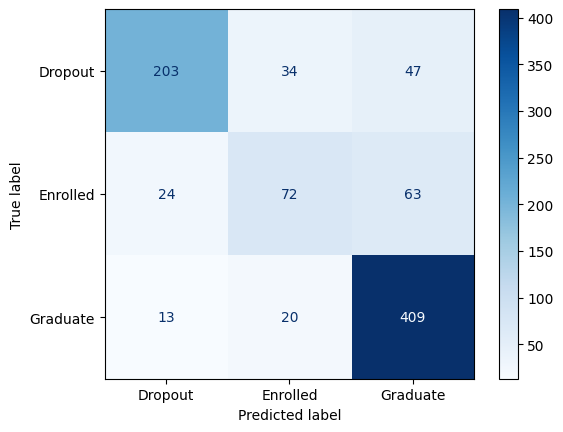

In [91]:
params_grid={
    'max_depth':[5],
    'learning_rate':[0.2],
    'gamma':[0.25],
    'reg_lambda':[6.0,7.0],
}
grid_search=GridSearchCV(clf_xgb, param_grid=params_grid, scoring='recall_macro', n_jobs=10, cv=3, verbose=2)
grid_search.fit(X_train,y_resampled)
best_params = grid_search.best_params_
best_estimator = grid_search.best_estimator_

print("Best parameters found: ", best_params)
predict=grid_search.predict(X_test)
confusion_matrix(y_test, predict)
print(classification_report(y_test, predict))
print("Accuracy: ", accuracy_score(y_test, predict))
ConfusionMatrixDisplay.from_estimator(grid_search,X_test,y_test,display_labels=['Dropout', 'Enrolled', 'Graduate'],cmap=plt.cm.Blues)

In [ ]:
weight_options = {
    'class_0': [.2,.3,.4,.5,.6,.7,.8,.9,1],
    'class_1': [1.1,1.2,1.3,1.4,1.5,1.6,1.7,1.8,1.9,2],
    'class_2': [.2,.3,.4,.5,.6,.7,.8,.9,1]
}
weight_combinations=[]
for w0 in weight_options['class_0']:
    for w1 in weight_options['class_1']:
        for w2 in weight_options['class_2']:
            dic={}
            dic[0]=w0
            dic[1]=w1
            dic[2]=w2
            weight_combinations.append(dic)
weight_combinations

In [18]:
def weight_optimizer(X_test,y_test,X_resampled,y_resampled,weight_combinations,best_params = {},best_weights = None,best_f1_score=0):
    for weights in weight_combinations:
        weight = class_weight.compute_sample_weight(weights, y=y_resampled)
        # Train the model
        best_params['num_class']=3
        best_params['device']='cuda'
        best_params['tree_method']='hist'
        best_params['eval_metric']= 'aucpr'
        best_params['early_stopping_rounds']=20
        best_params['objective']= 'multi:softprob'
        best_params['random_state']= 1
        model = XGBClassifier(**best_params)
        model.fit(X_resampled, y_resampled,sample_weight=weight,verbose=True,eval_set=[(X_test,y_test)])

        # Convert probabilities to class labels
        predict = model.predict(X_test)
        # Get the precision, recall, f1-score, and support
        precision, recall, f1_score, support = precision_recall_fscore_support(y_test, predict)

        # Find the index of the smallest f1 score
        min_index = f1_score.argmin()

        if f1_score[min_index]>best_f1_score:
            best_weights=weights
            best_f1_score=f1_score[min_index]
            best_f1_score
            best_report=classification_report(y_test, predict)
    print(best_f1_score)
    print(best_weights)
    print(best_report)
    return best_weights

In [19]:
def hyperparameter_optimizer(X_resampled,y_resampled,estimator,param_grid,scoring,n_jobs=4,cv=3,verbose=2,sample_weight=None,n_iter=180):
    weights = class_weight.compute_sample_weight(sample_weight, y=y_resampled)
    rand_search=RandomizedSearchCV(estimator=estimator, param_distributions=param_grid, scoring=scoring, n_jobs=n_jobs, cv=cv, verbose=verbose,n_iter=n_iter)
    rand_search.fit(X_resampled,y_resampled,sample_weight=weights,eval_set=[(X_test,y_test)])
    best_params = rand_search.best_params_
    return best_params

In [44]:
def model_rating(X_test,y_test,X_resampled,y_resampled,params,ranking=None,weights={0:1,1:1,2:1}):    
    if ranking!=None:
        id=sorted(ranking, key=lambda x: x['id'], reverse=True)[0]['id']+1
    if ranking==None:
        ranking=[]
        id=1
    weight = class_weight.compute_sample_weight(weights, y=y_resampled)   
    params['num_class']=3
    params['device']='cuda'
    params['tree_method']='hist'
    params['eval_metric']= 'aucpr'
    params['early_stopping_rounds']=20
    params['objective']= 'multi:softprob'
    params['random_state']= 1    # create model
    model = XGBClassifier(**params)
    model.fit(X_resampled,y_resampled,sample_weight=weight,verbose=True, eval_set=[(X_test,y_test)])
    predict = model.predict(X_test)
    
    # Get the precision, recall, f1-score, and support
    precision, recall, f1_score, support = precision_recall_fscore_support(y_test, predict)
    accuracy = accuracy_score(y_test, predict)
    # Find the index of the smallest f1 score
    min_f1 = f1_score.argmin()
    min_recall = recall.argmin()
    min_precision = precision.argmin()
    full_report=classification_report(y_test, predict)
    entry= {'id':id,'weights':weights,'parameters':params,'f1':f1_score[min_f1],'recall':recall[min_recall],'precision':precision[min_precision],'accuracy':accuracy,'full_report':full_report}
    ranking.append(entry)
    best_f1_score = sorted(ranking, key=lambda x: x['f1'], reverse=True)
    best_recall = sorted(ranking, key=lambda x: x['recall'], reverse=True)
    best_precision = sorted(ranking, key=lambda x: x['precision'], reverse=True)
    best_accuracy = sorted(ranking, key=lambda x: x['accuracy'], reverse=True)
    print('The best f1: ',best_f1_score[0])
    print('The best recall: ',best_recall[0])    
    print('The best precision: ',best_precision[0])  
    print('The best accuracy: ',best_accuracy[0])

    return ranking, best_f1_score[0]['f1'], best_recall[0]['recall'], best_precision[0]['precision'], best_accuracy[0]['accuracy']

In [21]:
def opt(path,delimiter,target_column,categorical,base_params={}):
    X_train,X_test,y_train,y_test = load_data(
        path=path,delimiter = delimiter,
        target_column=target_column,
        categorical=categorical
        )
    # Define the SMOTE method
    base_params['num_class']=3
    base_params['device']='cuda'
    base_params['tree_method']='hist'
    base_params['eval_metric']= 'aucpr'
    base_params['early_stopping_rounds']=20
    base_params['objective']= 'multi:softprob'
    base_params['random_state']= 1    # create model
    smote=SMOTE()
    X_resampled, y_resampled = smote.fit_resample(X_train, y_train)

    xgb_clf=XGBClassifier(**base_params)
    xgb_clf.fit(X_resampled,y_resampled,eval_set=[(X_test,y_test)])

    # Create weights to test
    weight_options = {
        'class_0': [.2,.3,.4,.5,.6,.7,.8,.9,1],
        'class_1': [1.1,1.2,1.3,1.4,1.5,1.6,1.7,1.8,1.9,2],
        'class_2': [.2,.3,.4,.5,.6,.7,.8,.9,1]
    }
    weight_combinations=[]
    for w0 in weight_options['class_0']:
        for w1 in weight_options['class_1']:
            for w2 in weight_options['class_2']:
                dic={}
                dic[0]=w0
                dic[1]=w1
                dic[2]=w2
                weight_combinations.append(dic)
    weight_combinations
    params = {'gamma': uniform(0,.5), 'learning_rate': uniform(.05,.25), 'max_depth': randint(3,7), 'reg_lambda': randint(1,10), 'subsample': uniform(.2,.7)}
    #
    best_params = hyperparameter_optimizer(X_resampled,y_resampled,xgb_clf,param_grid=params,scoring='f1_weighted')
    best_weights = weight_optimizer(X_test,y_test,X_resampled,y_resampled,weight_combinations,best_params=best_params)
    improvement_threshold = 0.01  # Minimum improvement to continue optimization
    previous_best_score = 0
    ranking, best_f1_score, best_recall, best_precision = model_rating(X_test,y_test,X_resampled,y_resampled,params=best_params,weights=best_weights)
    current_best_score = best_f1_score
    while current_best_score - previous_best_score > improvement_threshold:
        previous_best_score = current_best_score
        # Refine hyperparameters with current best weights
        best_params = hyperparameter_optimizer(X_resampled,y_resampled,xgb_clf,param_grid=params,scoring='f1_weighted',sample_weight=best_weights)

        # Refine weights with current best hyperparameters
        best_weights = best_weights = weight_optimizer(X_test,y_test,X_resampled,y_resampled,weight_combinations,best_params=best_params)

        # Evaluate the model with the new hyperparameters and weights
        ranking, best_f1_score, best_recall, best_precision = model_rating(X_test,y_test,X_resampled,y_resampled,params=best_params,weights=best_weights,ranking=ranking)
        current_best_score = best_f1_score
    # Final evaluation with the test set
    best_f1_score = sorted(ranking, key=lambda x: x['f1'], reverse=True)
    best_recall = sorted(ranking, key=lambda x: x['recall'], reverse=True)
    best_precision = sorted(ranking, key=lambda x: x['precision'], reverse=True)
    print(best_precision[0]['full_report'])
    model_p=best_precision[0]
    print(best_recall[0]['full_report'])
    model_r=best_recall[0]
    print(best_f1_score[0]['full_report'])
    model_f=best_f1_score[0]
    return model_p, model_r, model_f

In [22]:
path='Resources/data.csv'
delimiter = ';'
target_column='Target'
categorical=['Marital status','Application mode','Course','Previous qualification','Nacionality',"Mother's qualification","Father's qualification","Mother's occupation","Father's occupation",]
model_p, model_r, model_f = opt(path,delimiter,target_column,categorical)
print(model_f['full_report'])

Target
2    2209
0    1421
1     794
Name: count, dtype: int64
[0]	validation_0-aucpr:0.69732
[1]	validation_0-aucpr:0.72678
[2]	validation_0-aucpr:0.72852
[3]	validation_0-aucpr:0.72802
[4]	validation_0-aucpr:0.73634
[5]	validation_0-aucpr:0.73355
[6]	validation_0-aucpr:0.73793
[7]	validation_0-aucpr:0.73647
[8]	validation_0-aucpr:0.74349
[9]	validation_0-aucpr:0.74706
[10]	validation_0-aucpr:0.74331
[11]	validation_0-aucpr:0.74619
[12]	validation_0-aucpr:0.75371
[13]	validation_0-aucpr:0.75314
[14]	validation_0-aucpr:0.75216
[15]	validation_0-aucpr:0.74895
[16]	validation_0-aucpr:0.75020
[17]	validation_0-aucpr:0.75136
[18]	validation_0-aucpr:0.75414
[19]	validation_0-aucpr:0.75450
[20]	validation_0-aucpr:0.75514
[21]	validation_0-aucpr:0.75677
[22]	validation_0-aucpr:0.75483
[23]	validation_0-aucpr:0.75376
[24]	validation_0-aucpr:0.75206
[25]	validation_0-aucpr:0.75059
[26]	validation_0-aucpr:0.74947
[27]	validation_0-aucpr:0.74943
[28]	validation_0-aucpr:0.74582
[29]	validation_0-a

c:\Users\p0pp1\miniconda3\Lib\site-packages\xgboost\core.py:160: UserWarning: [21:22:34] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\common\error_msg.cc:58: Falling back to prediction using DMatrix due to mismatched devices. This might lead to higher memory usage and slower performance. XGBoost is running on: cuda:0, while the input data is on: cpu.
Potential solutions:
- Use a data structure that matches the device ordinal in the booster.
- Set the device for booster before call to inplace_predict.

This warning will only be shown once.

  warnings.warn(smsg, UserWarning)


[2]	validation_0-aucpr:0.70024
[3]	validation_0-aucpr:0.70438
[4]	validation_0-aucpr:0.71232
[5]	validation_0-aucpr:0.70954
[6]	validation_0-aucpr:0.70955
[7]	validation_0-aucpr:0.71410
[8]	validation_0-aucpr:0.71949
[9]	validation_0-aucpr:0.73617
[10]	validation_0-aucpr:0.73467
[11]	validation_0-aucpr:0.73223
[12]	validation_0-aucpr:0.73198
[13]	validation_0-aucpr:0.73648
[14]	validation_0-aucpr:0.73549
[15]	validation_0-aucpr:0.73336
[16]	validation_0-aucpr:0.73323
[17]	validation_0-aucpr:0.73575
[18]	validation_0-aucpr:0.74149
[19]	validation_0-aucpr:0.74201
[20]	validation_0-aucpr:0.74042
[21]	validation_0-aucpr:0.74109
[22]	validation_0-aucpr:0.73855
[23]	validation_0-aucpr:0.73906
[24]	validation_0-aucpr:0.73918
[25]	validation_0-aucpr:0.73954
[26]	validation_0-aucpr:0.74062
[27]	validation_0-aucpr:0.74004
[28]	validation_0-aucpr:0.74098
[29]	validation_0-aucpr:0.74151
[30]	validation_0-aucpr:0.74205
[31]	validation_0-aucpr:0.74158
[32]	validation_0-aucpr:0.74389
[33]	validation_

In [39]:
print(model_f['parameters'])
print(model_f['weights'])
print(model_f['full_report'])

{'gamma': 0.12551745193228736, 'learning_rate': 0.2120263249715012, 'max_depth': 6, 'reg_lambda': 1, 'subsample': 0.6676649565526603, 'num_class': 3, 'device': 'cuda', 'tree_method': 'hist', 'eval_metric': 'aucpr', 'early_stopping_rounds': 100, 'objective': 'multi:softprob', 'random_state': 1}
{0: 0.8, 1: 1.9, 2: 0.9}
              precision    recall  f1-score   support

           0       0.88      0.69      0.77       284
           1       0.49      0.70      0.58       159
           2       0.85      0.84      0.84       442

    accuracy                           0.77       885
   macro avg       0.74      0.74      0.73       885
weighted avg       0.79      0.77      0.77       885



Target
2    2209
0    1421
1     794
Name: count, dtype: int64
[0]	validation_0-aucpr:0.68731
[1]	validation_0-aucpr:0.69869
[2]	validation_0-aucpr:0.71105
[3]	validation_0-aucpr:0.71700
[4]	validation_0-aucpr:0.72533
[5]	validation_0-aucpr:0.72892
[6]	validation_0-aucpr:0.72869
[7]	validation_0-aucpr:0.73002
[8]	validation_0-aucpr:0.73114
[9]	validation_0-aucpr:0.73914
[10]	validation_0-aucpr:0.73818
[11]	validation_0-aucpr:0.74097
[12]	validation_0-aucpr:0.73832
[13]	validation_0-aucpr:0.73899
[14]	validation_0-aucpr:0.74053
[15]	validation_0-aucpr:0.74280
[16]	validation_0-aucpr:0.74000
[17]	validation_0-aucpr:0.74250
[18]	validation_0-aucpr:0.74604
[19]	validation_0-aucpr:0.74387
[20]	validation_0-aucpr:0.74214
[21]	validation_0-aucpr:0.74230
[22]	validation_0-aucpr:0.74281
[23]	validation_0-aucpr:0.74574
[24]	validation_0-aucpr:0.74419
[25]	validation_0-aucpr:0.74433
[26]	validation_0-aucpr:0.74273
[27]	validation_0-aucpr:0.74219
[28]	validation_0-aucpr:0.74417
[29]	validation_0-a

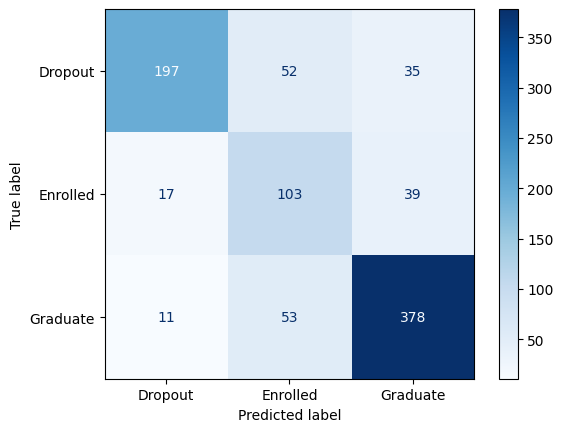

In [41]:
X_train,X_test,y_train,y_test=load_data(path=path,target_column=target_column,categorical=categorical,delimiter=delimiter)
smote=SMOTE()
X_resampled, y_resampled = smote.fit_resample(X_train, y_train)
model_f['parameters']['early_stopping_rounds']=100
xgb_clf=XGBClassifier(**model_f['parameters'])
weight_02=class_weight.compute_sample_weight(model_f['weights'],y=y_resampled)
xgb_clf.fit(X_resampled,y_resampled,sample_weight=weight_02,eval_set=[(X_test,y_test)])
predict=xgb_clf.predict(X_test)
confusion_matrix(y_test, predict)
print(classification_report(y_test, predict))
print("Accuracy: ", accuracy_score(y_test, predict))
ConfusionMatrixDisplay.from_estimator(xgb_clf,X_test,y_test,display_labels=['Dropout', 'Enrolled', 'Graduate'],cmap=plt.cm.Blues)

In [42]:
import joblib

# Save the model
joblib.dump(xgb_clf, 'xgb_model.pkl')

# To load the model later
# xgb_clf = joblib.load('xgb_model.pkl')


['xgb_model.pkl']